<a href="https://colab.research.google.com/github/achanhon/coursdeeplearningcolab/blob/master/TP_ADVERSAIRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TP deep learning sous attaque adversaire (2024)
####Adrien Chan-Hon-Tong
####TP réalisé à partir de résultats de Pol Labarbarie


L'objet de ce TP est de démontrer
- la faciliter de produire des attaques adversaires "white box" sur des réseaux naifs quelles soient invisibles ou par patch
- mais que cela est beaucoup plus dur sur un réseau robustifier (cas invisible)
- ou encore qu'il est beaucoup plus difficile de produire des attaques "transferable"

## generalité
Commençons par télécharger 10 images d'imagenet.

In [1]:
!rm -f *
!wget https://httpmail.onera.fr/21/500df56b6a7a034ecc2f3e0345f1ce9cYqsE3G/data.zip
!unzip data.zip
!ls

rm: cannot remove 'sample_data': Is a directory
--2024-09-25 07:25:55--  https://httpmail.onera.fr/21/500df56b6a7a034ecc2f3e0345f1ce9cYqsE3G/data.zip
Resolving httpmail.onera.fr (httpmail.onera.fr)... 144.204.16.9
Connecting to httpmail.onera.fr (httpmail.onera.fr)|144.204.16.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 723589 (707K) [application/force-download]
Saving to: ‘data.zip’

data.zip            100%[===================>] 706.63K   993KB/s    in 0.7s    

2024-09-25 07:25:57 (993 KB/s) - ‘data.zip’ saved [723589/723589]

Archive:  data.zip
 extracting: 0.png                   
  inflating: 1.png                   
 extracting: 2.png                   
 extracting: 3.png                   
  inflating: 4.png                   
 extracting: 5.png                   
 extracting: 6.png                   
 extracting: 7.png                   
 extracting: 8.png                   
 extracting: 9.png                   
0.png  1.png  2.png  3.png  4.png 

Affichons les : les 5 premières sont des "avions" et les 5 suivantes des "requins"

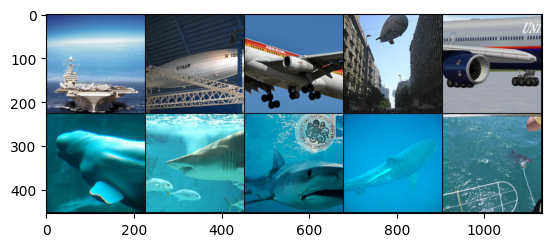

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt

x = [torchvision.io.read_image(str(i)+".png") for i in range(10)]
x = torch.stack(x,dim=0).float()/255

visu = torchvision.utils.make_grid(x, nrow=5)
plt.imshow(visu.permute(1, 2, 0).numpy())
plt.show()

In [3]:
SHARK, PLANE = [2, 3, 4], [403, 404, 405]
normalize = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
resnet = torchvision.models.resnet101(
    weights=torchvision.models.ResNet101_Weights.IMAGENET1K_V1
).eval()

with torch.no_grad():
    z = resnet(normalize(x))
    _,z = z.max(1)
    print(z)

tensor([403, 405, 404, 405, 404,   4,   3,   3,   3,   2])


On voit que le réseau classe correctement ces images.

## Attaque standard "white box"

On va maintenant rajouter à ces images un petit bruit "invisible" pour l'oeil mais perturbant pour le réseau.

In [4]:
y = torch.Tensor([403, 405, 404, 405, 404,   4,   3,   3,   3,   2]).long()
cefunction = torch.nn.CrossEntropyLoss()
attaque = torch.nn.Parameter(torch.zeros(x.shape))
optimizer = torch.optim.SGD([attaque],lr=0.005)
for i in range(10):
  z = resnet(normalize(x+attaque))
  ce = cefunction(z,y)
  print(i,float(ce))
  ce = -ce # on veut MAXIMISER la cross entropy puisqu'on attaque
  optimizer.zero_grad()
  ce.backward()
  attaque.grad = attaque.grad.sign()
  optimizer.step()
  with torch.no_grad():
      # l'attaque doit être invisible
      attaque = torch.clamp(attaque, -10./255,+10./255)

      # attaque+x doit être entre 0 et 1
      lowbound = -x
      uppbound = 1-x
      attaque = lowbound*(attaque<lowbound).float() + uppbound*(attaque>uppbound).float() + attaque *(attaque>=lowbound).float()*(attaque<=uppbound).float()

  attaque = torch.nn.Parameter(attaque.clone())
  optimizer = torch.optim.SGD([attaque],lr=0.005)

0 0.04686766862869263
1 3.540823459625244
2 9.229753494262695
3 15.51185417175293
4 22.443988800048828
5 28.232580184936523
6 33.313053131103516
7 38.62725830078125
8 39.327423095703125
9 44.154701232910156


80% des images "x+attaque" sont désormais mal classées ! (et le label de toutes à changer)
Pourtant, l'attaque ne se voit pas :

tensor([403, 405, 404, 405, 404,   4,   3,   3,   3,   2])
tensor([562, 517, 657, 682, 709, 149, 296,   2, 845,   4])


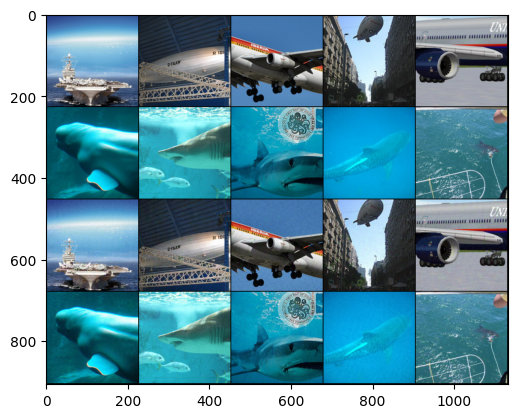

In [6]:
with torch.no_grad():
    z = resnet(normalize(x))
    _,z = z.max(1)
    print(z)
    z = resnet(normalize(x+attaque))
    _,z = z.max(1)
    print(z)

visu = torch.cat([x,x+attaque],dim=0)
visu = torchvision.utils.make_grid(visu, nrow=5)
plt.imshow(visu.permute(1, 2, 0).numpy())
plt.show()

Comment est ce que c'est possible ? Les réseaux ne sont pas du tout lipschitziens...

In [12]:
with torch.no_grad():
    resnet = torchvision.models.resnet101(
        weights=torchvision.models.ResNet101_Weights.IMAGENET1K_V1
    ).eval()
    resnet.fc = torch.nn.Identity()
    z = resnet(x)
    print(((z[0]-z[5])**2).sum())
    z_ = resnet(x+attaque)
    print(((z[0]-z_[0])**2).sum())

tensor(774.0449)
tensor(506.3102)


On voit que la représentation de l'image 0 devient presque aussi lointaine à cause de l'attaque que la distance avec l'image 5 !
Alors que nous ne voyons même pas la différence !

=> retour aux slides (on revient ici après).

# Attaque standard par patch "white box"
Maintenant on va regarder la création d'un patch adversarial : pour rappel, le problème des bruits invisibles c'est l'impossibilité de les faire dans le monde physique et l'existance de défense -> deux choses que les patches peuvent bypasser.

On va mettre un patch 36x36 en haut à gauche (remarquons que si le patch est juste noir, ça change rien).

tensor([403, 405, 404, 405, 404,   4,   3,   3,   3,   2])
tensor([403, 405, 404, 405, 404,   4,   3,   3,   3,   2])


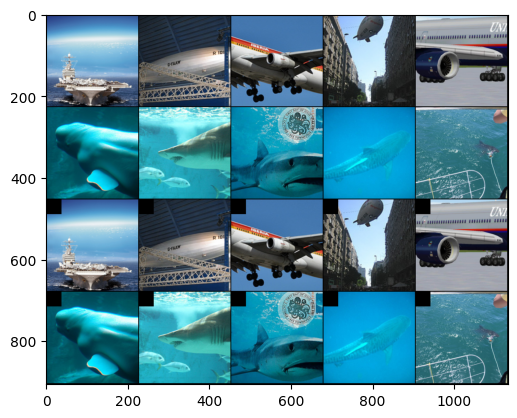

In [18]:
mask = torch.zeros(1,3,224,224)
mask[:,:,0:36,0:36] = 1

resnet = torchvision.models.resnet101(
    weights=torchvision.models.ResNet101_Weights.IMAGENET1K_V1
).eval()
with torch.no_grad():
    z = resnet(normalize(x))
    _,z = z.max(1)
    print(z)
    z = resnet(normalize(x*(1-mask)))
    _,z = z.max(1)
    print(z)

visu = torch.cat([x,x*(1-mask)],dim=0)
visu = torchvision.utils.make_grid(visu, nrow=5)
plt.imshow(visu.permute(1, 2, 0).numpy())
plt.show()

mais s'il est optimisé ?

In [21]:
y = torch.Tensor([403, 405, 404, 405, 404,   4,   3,   3,   3,   2]).long()
cefunction = torch.nn.CrossEntropyLoss()
attaque = torch.nn.Parameter(torch.rand(1,3,224,224))
optimizer = torch.optim.SGD([attaque],lr=0.1)
for i in range(20):
  z = resnet(normalize(x*(1-mask)+mask*attaque))
  ce = cefunction(z,y)
  print(i,float(ce))
  ce = -ce # on veut MAXIMISER la cross entropy puisqu'on attaque
  optimizer.zero_grad()
  ce.backward()
  attaque.grad = attaque.grad.sign()
  optimizer.step()
  with torch.no_grad():
      # l'attaque doit être dans le domaine image
      attaque = torch.clamp(attaque, 0,1)

  attaque = torch.nn.Parameter(attaque.clone())
  optimizer = torch.optim.SGD([attaque],lr=0.1)

0 0.052073292434215546
1 0.0633297711610794


KeyboardInterrupt: 